In [21]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

In [22]:
from gbd_mapping import risk_factors
from vivarium_inputs import get_measure
from operator import attrgetter

In [23]:
output_dirs = ['/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/india/2020_02_06_17_37_48/count_data/',
                '/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/pakistan/2020_02_06_17_38_45/count_data/',
              '/share/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/tanzania/2020_02_06_17_39_16/count_data/',
              '/share/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/mali/2020_02_06_17_38_33/count_data/']

locations = ['India',
            'Pakistan',
            'Tanzania',
            'Mali']

In [24]:
master_pt = pd.DataFrame()
for i in list(range(len(output_dirs))):
    pt = pd.read_hdf(output_dirs[i] + 'person_time.hdf')
    pt = pt.where(pt['scenario'] == 'baseline').dropna().drop(columns=['scenario','measure'])
    pt = pt.where(pt['age_group'].isin(['1mo_to_6mo','6mo_to_1','1_to_4'])).dropna()
    pt = pt.groupby(['age_group','input_draw'], as_index=False).sum()
    pt = pt.groupby('age_group', as_index=False).mean().drop(columns='input_draw')
    pt['location'] = locations[i] 
    pt_over_1 = pt.where(pt['age_group'] == '1_to_4').dropna()
    pt_under_1 = pt.where(pt['age_group'].isin(['1mo_to_6mo','6mo_to_1'])).dropna()
    pt_under_1 = pt.groupby('location', as_index=False).sum()
    pt_under_1['age_group'] = '6mo_to_1'
    pt = pt_over_1.append(pt_under_1).rename(columns={'value':'person_time'})
    master_pt = master_pt.append(pt)
master_pt

/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,age_group,location,person_time
0,1_to_4,India,97265.096372
0,6mo_to_1,India,187740.828351
0,1_to_4,Pakistan,96154.572279
0,6mo_to_1,Pakistan,185706.952609
0,1_to_4,Tanzania,96169.066010
0,6mo_to_1,Tanzania,186187.669095
0,1_to_4,Mali,93760.383641
0,6mo_to_1,Mali,182440.494951


In [25]:
stunting = pd.DataFrame()
for location in ['India','Mali','Pakistan','Tanzania']:
    data = get_measure(risk_factors.child_stunting, 'exposure', location)
    data = pd.DataFrame(data.mean(axis=1)).rename(columns={0:'exposure'}).reset_index()
    data['year'] = data['year'].map(attrgetter('left'))
    data = data.where(data['year'] == 2017).dropna()
    data['age_start'] = data['age'].map(attrgetter('left'))
    data['age_end'] = data['age'].map(attrgetter('right'))
    data = data.where(data['age_start'] < 5).where(data['age_start'] > 0.07).dropna().drop(columns=['year','age'])
    data['age_group'] = np.where(data['age_end'] == 1, '1mo_to_6mo', '1_to_4')
    data = data.drop(columns=['age_start','age_end'])
    stunting = stunting.append(data)
stunted = stunting.groupby(['location','parameter','age_group'], as_index=False).mean()
stunted = stunted.where(stunted['parameter'].isin(['cat1','cat2'])).dropna()
stunted = stunted.groupby(['location','age_group'], as_index=False).sum().sort_values(by='location')
stunted = stunted.merge(master_pt, right_on=['location','age_group'], left_on=['location','age_group'])
stunted['weighted_exposure'] = stunted['exposure'] * stunted['person_time']
stunted = stunted.groupby('location', as_index=False).sum()
stunted['average_exposure'] = stunted['weighted_exposure'] / stunted['person_time']
stunted.head()

/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/vivarium_inputs/validation/raw.py:1405: UserWarning: Risk_factor child_stunting exposure data may violate the following restrictions:  age restriction.
  warnings.warn(f'{entity.kind.capitalize()} {entity.name} {measure} data may violate the '
/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/vivarium_inputs/validation/raw.py:1960: UserWarning: Data was only expected to contain values for age groups between ids 4 and 5 but also included values for age groups {2, 3}.
  warnings.warn(f'Data was only expected to contain values for age groups between ids '
/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/vivarium_inputs/validation/raw.py:1405: UserWarning: Risk_factor child_stunting exposure data may violate the following restrictions:  age restriction.
  warnings.warn(f'{entity.kind.capitalize()} {entity.name} {measure} data may violate the '
/ihme/home

,location,exposure,person_time,weighted_exposure,average_exposure
0,India,0.417722,97265.096372,40629.726099,0.417722
1,Mali,0.369725,93760.383641,34665.580184,0.369725
2,Pakistan,0.453403,96154.572279,43596.749084,0.453403
3,Tanzania,0.388859,96169.066010,37396.219310,0.388859


In [26]:
wasting = pd.DataFrame()
for location in ['India','Mali','Pakistan','Tanzania']:
    data = get_measure(risk_factors.child_wasting, 'exposure', location)
    data = pd.DataFrame(data.mean(axis=1)).rename(columns={0:'exposure'}).reset_index()
    data['year'] = data['year'].map(attrgetter('left'))
    data = data.where(data['year'] == 2017).dropna()
    data['age_start'] = data['age'].map(attrgetter('left'))
    data['age_end'] = data['age'].map(attrgetter('right'))
    data = data.where(data['age_start'] < 5).where(data['age_start'] > 0.07).dropna().drop(columns=['year','age'])
    data['age_group'] = np.where(data['age_end'] == 1, '1mo_to_6mo', '1_to_4')
    data = data.drop(columns=['age_start','age_end'])
    wasting = wasting.append(data)
wasted = wasting.groupby(['location','parameter','age_group'], as_index=False).mean()
wasted = wasted.where(wasted['parameter'].isin(['cat1','cat2'])).dropna()
wasted = wasted.groupby(['location','age_group'], as_index=False).sum().sort_values(by='location')
wasted = wasted.merge(master_pt, right_on=['location','age_group'], left_on=['location','age_group'])
wasted['weighted_exposure'] = wasted['exposure'] * wasted['person_time']
wasted = wasted.groupby('location', as_index=False).sum()
wasted['average_exposure'] = wasted['weighted_exposure'] / wasted['person_time']
wasted.head()

/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/vivarium_inputs/validation/raw.py:1405: UserWarning: Risk_factor child_wasting exposure data may violate the following restrictions:  age restriction.
  warnings.warn(f'{entity.kind.capitalize()} {entity.name} {measure} data may violate the '
/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/vivarium_inputs/validation/raw.py:1954: UserWarning: Data was expected to contain all age groups between ids 2 and 235 but was missing the following: {6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 31, 32, 235}.
  warnings.warn(message)
/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/vivarium_inputs/validation/raw.py:1405: UserWarning: Risk_factor child_wasting exposure data may violate the following restrictions:  age restriction.
  warnings.warn(f'{entity.kind.capitalize()} {entity.name} {measure} data may violate the '
/ihme/homes/alibow/.conda/e

,location,exposure,person_time,weighted_exposure,average_exposure
0,India,0.154829,97265.096372,15059.504732,0.154829
1,Mali,0.126888,93760.383641,11897.085121,0.126888
2,Pakistan,0.125700,96154.572279,12086.632779,0.125700
3,Tanzania,0.040655,96169.066010,3909.787283,0.040655


In [27]:
master_bw = pd.DataFrame()

for i in list(range(len(output_dirs))):
    bw = pd.read_hdf(output_dirs[i] + 'birth_weight.hdf').reset_index().sort_values(by=['risk','measure','scenario','treatment_group','mother_status'])
    pop = pd.read_hdf(output_dirs[i] + 'population.hdf').reset_index()
    pop = pop.where(pop['measure'] == 'total_population').dropna().rename(columns={'value':'total_population'}).drop(columns=['index','measure'])
    data = bw.merge(pop, right_on=['scenario','treatment_group','mother_status','input_draw'], left_on=['scenario','treatment_group','mother_status','input_draw'])
    data = data.groupby(['risk','measure','scenario','treatment_group','mother_status']).mean().drop(columns=['input_draw','index']).reset_index()
    data['weighted_value'] = data['value'] * data['total_population']
    data['location'] = locations[i]
    master_bw = master_bw.append(data)
    
master_bw.head()

,risk,measure,scenario,treatment_group,mother_status,value,total_population,weighted_value,location
0,birth_weight,mean,baseline,bep,malnourished,0.000000,0.00,0.000000e+00,India
1,birth_weight,mean,baseline,bep,normal,0.000000,0.00,0.000000e+00,India
2,birth_weight,mean,baseline,ifa,malnourished,2684.283214,5770.54,1.548976e+07,India
3,birth_weight,mean,baseline,ifa,normal,3038.537322,28261.14,8.587253e+07,India
4,birth_weight,mean,baseline,mmn,malnourished,0.000000,0.00,0.000000e+00,India


In [28]:
stratified = master_bw.groupby(['location','measure','scenario','mother_status']).sum()
stratified['weighted_average'] = stratified['weighted_value'] / stratified['total_population']
stratified = stratified.reset_index()
stratified = stratified.where(stratified['measure'] == 'proportion_below_2500g').where(stratified['scenario'] == 'baseline').dropna()
overall = master_bw.groupby(['location','measure','scenario']).sum()
overall['weighted_average'] = overall['weighted_value'] / overall['total_population']
overall = overall.reset_index()
overall = overall.where(overall['measure'] == 'proportion_below_2500g').where(overall['scenario'] == 'baseline').dropna()
overall = overall.sort_values(by='location')
overall.head()

,location,measure,scenario,value,total_population,weighted_value,weighted_average
4,India,proportion_below_2500g,baseline,1.050711,100000.0,20533.616853,0.205336
16,Mali,proportion_below_2500g,baseline,0.924956,100000.0,17034.532598,0.170345
28,Pakistan,proportion_below_2500g,baseline,1.232339,100000.0,22854.692210,0.228547
40,Tanzania,proportion_below_2500g,baseline,0.383842,100000.0,7014.718585,0.070147


(0, 0.62)

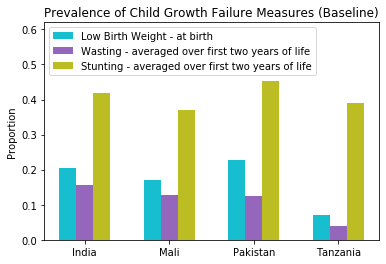

In [29]:
# bar width
barWidth = 0.2

# bar heights
lbw = list(overall['weighted_average'])
stunted_plot = stunted['average_exposure']
wasted_plot = wasted['average_exposure']

# bar positions
a = np.arange(len(lbw))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]

# plot 
plt.bar(a, lbw, width=barWidth, color='tab:cyan')
plt.bar(b, wasted_plot, width=barWidth, color='tab:purple')
plt.bar(c, stunted_plot, width=barWidth, color='tab:olive')
plt.xticks([r + barWidth for r in range(len(lbw))], np.unique(overall['location']))
plt.legend(['Low Birth Weight - at birth',
            'Wasting - averaged over first two years of life',
            'Stunting - averaged over first two years of life'],
          loc='upper left')
plt.title('Prevalence of Child Growth Failure Measures (Baseline)')
plt.ylabel('Proportion')
plt.ylim(0, 0.62)

In [30]:
stratified = master_bw.groupby(['location','measure','scenario','mother_status']).sum()
stratified['weighted_average'] = stratified['weighted_value'] / stratified['total_population']
stratified = stratified.reset_index()
stratified = stratified.where(stratified['measure'] == 'proportion_below_2500g').dropna()#.where(stratified['scenario'] == 'baseline').dropna()
overall = master_bw.groupby(['location','measure','scenario']).sum()
overall['weighted_average'] = overall['weighted_value'] / overall['total_population']
overall = overall.reset_index()
overall = overall.where(overall['measure'] == 'proportion_below_2500g').dropna()#.where(overall['scenario'] == 'baseline').dropna()
overall = overall.sort_values(by='location')
overall['mother_status'] = 'overall'
overall.head()

,location,measure,scenario,value,total_population,weighted_value,weighted_average,mother_status
4,India,proportion_below_2500g,baseline,1.050711,100000.0,20533.616853,0.205336,overall
5,India,proportion_below_2500g,bep_scale_up,0.962357,100000.0,18634.448821,0.186344,overall
6,India,proportion_below_2500g,bep_targeted_scale_up,0.972170,100000.0,19281.797461,0.192818,overall
7,India,proportion_below_2500g,mmn_scale_up,1.028540,100000.0,20039.761337,0.200398,overall
16,Mali,proportion_below_2500g,baseline,0.924956,100000.0,17034.532598,0.170345,overall


In [31]:
bw = stratified.append(overall)
baseline_bw = (bw.where(bw['scenario'] == 'baseline').dropna()
               .drop(columns=['scenario','weighted_value','total_population','value'])
               .rename(columns={'weighted_average':'baseline_value'}))
bw_diff = bw.merge(baseline_bw, right_on=['location','measure','mother_status'],
                  left_on=['location','measure','mother_status'])
bw_diff['averted'] = bw_diff['baseline_value'] - bw_diff['weighted_average']
bw_diff.head()

/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,location,measure,mother_status,scenario,total_population,value,weighted_average,weighted_value,baseline_value,averted
0,India,proportion_below_2500g,malnourished,baseline,16936.5,0.698741,0.349383,5917.325585,0.349383,0.000000
1,India,proportion_below_2500g,malnourished,bep_scale_up,16936.5,0.624356,0.292017,4945.741069,0.349383,0.057366
2,India,proportion_below_2500g,malnourished,bep_targeted_scale_up,16936.5,0.624356,0.292017,4945.741069,0.349383,0.057366
3,India,proportion_below_2500g,malnourished,mmn_scale_up,16936.5,0.680726,0.336770,5703.704944,0.349383,0.012613
4,India,proportion_below_2500g,normal,baseline,83063.5,0.351969,0.175965,14616.291268,0.175965,0.000000


(0, 1999)

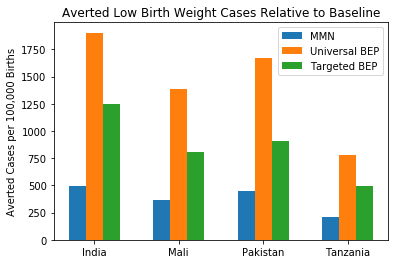

In [33]:
data = bw_diff.where(bw_diff['mother_status'] == 'overall').dropna()

# bar width
barWidth = 0.2

# bar heights
baseline = list(data['averted'].where(data['scenario'] == 'baseline').dropna()  * 100_000)
mmn = list(data['averted'].where(data['scenario'] == 'mmn_scale_up').dropna() * 100_000) 
bep = list(data['averted'].where(data['scenario'] == 'bep_scale_up').dropna() * 100_000) 
bep_targeted = list(data['averted'].where(data['scenario'] == 'bep_targeted_scale_up').dropna() * 100_000)
# bar positions
a = np.arange(len(mmn))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
# plot 
plt.bar(a, mmn, width=barWidth)
plt.bar(b, bep, width=barWidth)
plt.bar(c, bep_targeted, width=barWidth)
plt.xticks([r + barWidth for r in range(len(mmn))], np.unique(data['location']))
plt.legend(['MMN','Universal BEP','Targeted BEP'],
          loc='upper right')
plt.title('Averted Low Birth Weight Cases Relative to Baseline')
plt.ylabel('Averted Cases per 100,000 Births')
plt.ylim(0,1999)

Text(0, 0.5, 'Averted Cases per 100,000 Births')

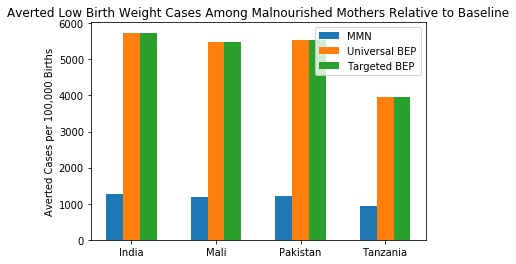

In [38]:
data = bw_diff.where(bw_diff['mother_status'] == 'malnourished').dropna()

# bar width
barWidth = 0.2

# bar heights
baseline = list(data['averted'].where(data['scenario'] == 'baseline').dropna()  * 100_000)
mmn = list(data['averted'].where(data['scenario'] == 'mmn_scale_up').dropna() * 100_000) 
bep = list(data['averted'].where(data['scenario'] == 'bep_scale_up').dropna() * 100_000) 
bep_targeted = list(data['averted'].where(data['scenario'] == 'bep_targeted_scale_up').dropna() * 100_000)
# bar positions
a = np.arange(len(mmn))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
# plot 
plt.bar(a, mmn, width=barWidth)
plt.bar(b, bep, width=barWidth)
plt.bar(c, bep_targeted, width=barWidth)
plt.xticks([r + barWidth for r in range(len(mmn))], np.unique(data['location']))
plt.legend(['MMN','Universal BEP','Targeted BEP'],
          loc='upper right')
plt.title('Averted Low Birth Weight Cases Among Malnourished Mothers Relative to Baseline')
plt.ylabel('Averted Cases per 100,000 Births')
#plt.ylim(0,1999)

In [39]:
bw_diff.head()

,location,measure,mother_status,scenario,total_population,value,weighted_average,weighted_value,baseline_value,averted
0,India,proportion_below_2500g,malnourished,baseline,16936.5,0.698741,0.349383,5917.325585,0.349383,0.000000
1,India,proportion_below_2500g,malnourished,bep_scale_up,16936.5,0.624356,0.292017,4945.741069,0.349383,0.057366
2,India,proportion_below_2500g,malnourished,bep_targeted_scale_up,16936.5,0.624356,0.292017,4945.741069,0.349383,0.057366
3,India,proportion_below_2500g,malnourished,mmn_scale_up,16936.5,0.680726,0.336770,5703.704944,0.349383,0.012613
4,India,proportion_below_2500g,normal,baseline,83063.5,0.351969,0.175965,14616.291268,0.175965,0.000000


Text(0, 0.5, 'Averted Cases per 100,000 Births')

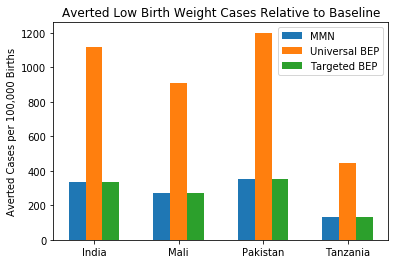

In [41]:
data = bw_diff.where(bw_diff['mother_status'] == 'normal').dropna()

# bar width
barWidth = 0.2

# bar heights
baseline = list(data['averted'].where(data['scenario'] == 'baseline').dropna()  * 100_000)
mmn = list(data['averted'].where(data['scenario'] == 'mmn_scale_up').dropna() * 100_000) 
bep = list(data['averted'].where(data['scenario'] == 'bep_scale_up').dropna() * 100_000) 
bep_targeted = list(data['averted'].where(data['scenario'] == 'bep_targeted_scale_up').dropna() * 100_000)
# bar positions
a = np.arange(len(mmn))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
# plot 
plt.bar(a, mmn, width=barWidth)
plt.bar(b, bep, width=barWidth)
plt.bar(c, bep_targeted, width=barWidth)
plt.xticks([r + barWidth for r in range(len(mmn))], np.unique(data['location']))
plt.legend(['MMN','Universal BEP','Targeted BEP'],
          loc='upper right')
plt.title('Averted Low Birth Weight Cases Relative to Baseline')
plt.ylabel('Averted Cases per 100,000 Births')
#plt.ylim(0,1999)

(0, 7500)

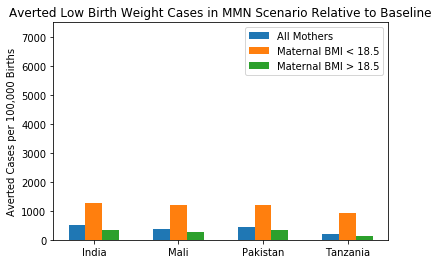

In [69]:
data = bw_diff.where(bw_diff['scenario'] == 'mmn_scale_up').dropna()
data = data.sort_values(by='location')

# bar width
barWidth = 0.2

# bar heights
all_mothers = list(data['averted'].where(data['mother_status'] == 'overall').dropna()  * 100_000)
malnourished_mothers = list(data['averted'].where(data['mother_status'] == 'malnourished').dropna() * 100_000) 
normal_mothers = list(data['averted'].where(data['mother_status'] == 'normal').dropna() * 100_000) 

# bar positions
a = np.arange(len(all_mothers))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
# plot 
plt.bar(a, all_mothers, width=barWidth)
plt.bar(b, malnourished_mothers, width=barWidth)
plt.bar(c, normal_mothers, width=barWidth)
plt.xticks([r + barWidth for r in range(len(all_mothers))], np.unique(data['location']))
plt.legend(['All Mothers','Maternal BMI < 18.5','Maternal BMI > 18.5'],
          loc='upper right')
plt.title('Averted Low Birth Weight Cases in MMN Scenario Relative to Baseline')
plt.ylabel('Averted Cases per 100,000 Births')
plt.ylim(0,7500)

(0, 7500)

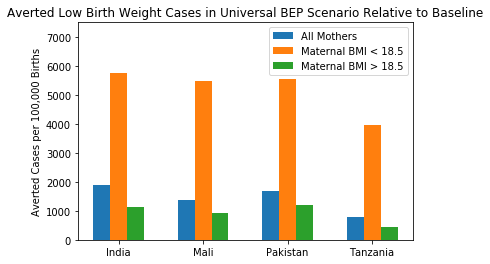

In [67]:
data = bw_diff.where(bw_diff['scenario'] == 'bep_scale_up').dropna()
data = data.sort_values(by='location')

# bar width
barWidth = 0.2

# bar heights
all_mothers = list(data['averted'].where(data['mother_status'] == 'overall').dropna()  * 100_000)
malnourished_mothers = list(data['averted'].where(data['mother_status'] == 'malnourished').dropna() * 100_000) 
normal_mothers = list(data['averted'].where(data['mother_status'] == 'normal').dropna() * 100_000) 

# bar positions
a = np.arange(len(all_mothers))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
# plot 
plt.bar(a, all_mothers, width=barWidth)
plt.bar(b, malnourished_mothers, width=barWidth)
plt.bar(c, normal_mothers, width=barWidth)
plt.xticks([r + barWidth for r in range(len(all_mothers))], np.unique(data['location']))
plt.legend(['All Mothers','Maternal BMI < 18.5','Maternal BMI > 18.5'],
          loc='upper right')
plt.title('Averted Low Birth Weight Cases in Universal BEP Scenario Relative to Baseline')
plt.ylabel('Averted Cases per 100,000 Births')
plt.ylim(0,7500)

(0, 7500)

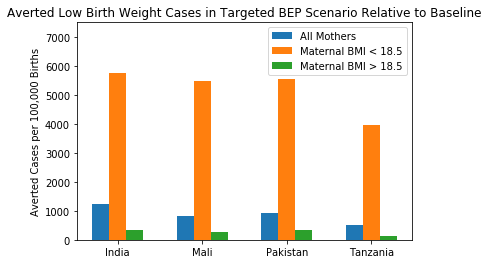

In [66]:
data = bw_diff.where(bw_diff['scenario'] == 'bep_targeted_scale_up').dropna()
data = data.sort_values(by='location')

# bar width
barWidth = 0.2

# bar heights
all_mothers = list(data['averted'].where(data['mother_status'] == 'overall').dropna()  * 100_000)
malnourished_mothers = list(data['averted'].where(data['mother_status'] == 'malnourished').dropna() * 100_000) 
normal_mothers = list(data['averted'].where(data['mother_status'] == 'normal').dropna() * 100_000) 

# bar positions
a = np.arange(len(all_mothers))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
# plot 
plt.bar(a, all_mothers, width=barWidth)
plt.bar(b, malnourished_mothers, width=barWidth)
plt.bar(c, normal_mothers, width=barWidth)
plt.xticks([r + barWidth for r in range(len(all_mothers))], np.unique(data['location']))
plt.legend(['All Mothers','Maternal BMI < 18.5','Maternal BMI > 18.5'],
          loc='upper right')
plt.title('Averted Low Birth Weight Cases in Targeted BEP Scenario Relative to Baseline')
plt.ylabel('Averted Cases per 100,000 Births')
plt.ylim(0,7500)

(0, 600)

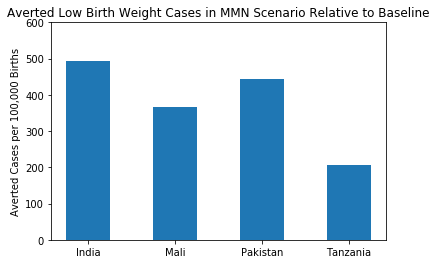

In [36]:
data = bw_diff.where(bw_diff['mother_status'] == 'overall').dropna()

# bar width
barWidth = 0.5

# bar heights
mmn = list(data['averted'].where(data['scenario'] == 'mmn_scale_up').dropna() * 100_000) 
# bar positions
a = np.arange(len(mmn))
# plot 
plt.bar(a, mmn, width=barWidth)
plt.xticks([r for r in range(len(mmn))], np.unique(data['location']))
plt.title('Averted Low Birth Weight Cases in MMN Scenario Relative to Baseline')
plt.ylabel('Averted Cases per 100,000 Births')
plt.ylim(0,600)

(0, 0.32)

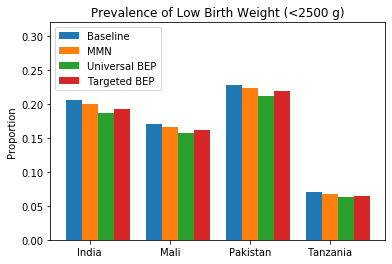

In [36]:
# bar width
barWidth = 0.2

# bar heights
baseline = list(overall['weighted_average'].where(overall['scenario'] == 'baseline').dropna())
mmn = list(overall['weighted_average'].where(overall['scenario'] == 'mmn_scale_up').dropna())
bep = list(overall['weighted_average'].where(overall['scenario'] == 'bep_scale_up').dropna())
bep_targeted = list(overall['weighted_average'].where(overall['scenario'] == 'bep_targeted_scale_up').dropna())

# bar positions
a = np.arange(len(baseline))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
d = [x + barWidth for x in c]

# plot 
plt.bar(a, baseline, width=barWidth)
plt.bar(b, mmn, width=barWidth)
plt.bar(c, bep, width=barWidth)
plt.bar(d, bep_targeted, width=barWidth)
plt.xticks([r + barWidth for r in range(len(lbw))], np.unique(overall['location']))
plt.legend(['Baseline','MMN','Universal BEP','Targeted BEP'],
          loc='upper left')
plt.title('Prevalence of Low Birth Weight (<2500 g)')
plt.ylabel('Proportion')
plt.ylim(0, 0.32)

In [ ]:
stratified = master_bw.groupby(['location','measure','scenario','mother_status']).sum()
stratified['weighted_average'] = stratified['weighted_value'] / stratified['total_population']
stratified = stratified.reset_index()
stratified = stratified.where(stratified['measure'] == 'proportion_below_2500g').where(stratified['scenario'] == 'baseline').dropna()
overall = master_bw.groupby(['location','measure','scenario']).sum()
overall['weighted_average'] = overall['weighted_value'] / overall['total_population']
overall = overall.reset_index()
overall = overall.where(overall['measure'] == 'proportion_below_2500g').where(overall['scenario'] == 'baseline').dropna()
overall['mother_status'] = 'all'
data = stratified.append(overall)
data = data.sort_values(by='location')

# bar width
barWidth = 0.2

# bar heights
overall = data['weighted_average'].where(data['mother_status'] == 'all').dropna()
normal = data['weighted_average'].where(data['mother_status'] == 'normal').dropna()
malnourished = data['weighted_average'].where(data['mother_status'] == 'malnourished').dropna()

# bar positions
a = np.arange(len(overall))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]

# plot 
plt.bar(a, overall, width=barWidth)
plt.bar(b, normal, width=barWidth)
plt.bar(c, malnourished, width=barWidth)
plt.xticks([r + barWidth for r in range(len(normal))], np.unique(data['location']))
plt.legend(['Overall','BMI > 18.5','BMI < 18.5'])
plt.title('Prevalence of Low Birth Weight (<2500 grams)')
plt.ylabel('Proportion')

/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(0, 4200)

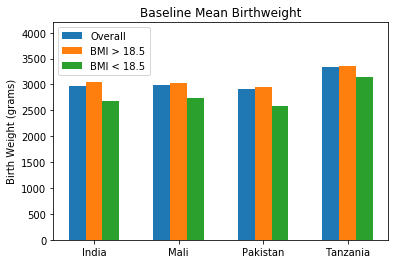

In [6]:
# plot baseline mean birth weight stratified by maternal malnourishment

stratified = master_bw.groupby(['location','measure','scenario','mother_status']).sum()
stratified['weighted_average'] = stratified['weighted_value'] / stratified['total_population']
stratified = stratified.reset_index()
stratified = stratified.where(stratified['measure'] == 'mean').where(stratified['scenario'] == 'baseline').dropna()
overall = master_bw.groupby(['location','measure','scenario']).sum()
overall['weighted_average'] = overall['weighted_value'] / overall['total_population']
overall = overall.reset_index()
overall = overall.where(overall['measure'] == 'mean').where(overall['scenario'] == 'baseline').dropna()
overall['mother_status'] = 'all'
data = stratified.append(overall)
data = data.sort_values(by='location')

# bar width
barWidth = 0.2

# bar heights
overall = data['weighted_average'].where(data['mother_status'] == 'all').dropna()
normal = data['weighted_average'].where(data['mother_status'] == 'normal').dropna()
malnourished = data['weighted_average'].where(data['mother_status'] == 'malnourished').dropna()

# bar positions
a = np.arange(len(overall))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]

# plot 
plt.bar(a, overall, width=barWidth)
plt.bar(b, normal, width=barWidth)
plt.bar(c, malnourished, width=barWidth)
plt.xticks([r + barWidth for r in range(len(normal))], np.unique(data['location']))
plt.legend(['Overall','BMI > 18.5','BMI < 18.5'])
plt.title('Baseline Mean Birthweight')
plt.ylabel('Birth Weight (grams)')
plt.ylim(0,4200)

In [7]:
bp = pd.read_hdf('/share/costeffectiveness/results/vivarium_gates_bep/malnutrition/india/2020_02_05_03_02_13/count_space/birth_prevalence.hdf').reset_index()
bp = bp.groupby(['input_draw','malnourishment_category']).sum().reset_index()
bp = pd.pivot_table(bp, index=['input_draw'], 
                     columns='malnourishment_category',
                    values='birth_prevalence').reset_index()
pop = pd.read_hdf('/share/costeffectiveness/results/vivarium_gates_bep/malnutrition/india/2020_02_05_03_02_13/count_space/population.hdf').reset_index()
pop = pop.where(pop['pop_state'] == 'tracked').dropna()
pop = pop.merge(bp, right_on='input_draw', left_on='input_draw').drop(columns='pop_state')
pop['overall_pct'] = (pop['malnourished'] + pop['not_malnourished']) / pop['population']
pop['malnourished_population'] = pop['malnourished'] / pop['overall_pct']
pop['not_malnourished_population'] = pop['not_malnourished'] / pop['overall_pct']
pop = pop.drop(columns=['malnourished','not_malnourished','overall_pct','population'])
temp = pop[['input_draw','malnourished_population']].rename(columns={'malnourished_population':'population'})
temp['malnourishment_category'] = 'malnourished'
temp2 = pop[['input_draw','not_malnourished_population']].rename(columns={'not_malnourished_population':'population'})
temp2['malnourishment_category'] = 'not_malnourished'
population = temp.append(temp2)
population.head()

,input_draw,population,malnourishment_category
0,29.0,12394.779293,malnourished
1,232.0,16557.848002,malnourished
2,357.0,15313.114461,malnourished
3,394.0,16604.251887,malnourished
4,602.0,15276.921861,malnourished


In [124]:
output_dirs = ['/share/costeffectiveness/results/vivarium_gates_bep/malnutrition/india/2020_02_05_03_02_13/count_space/',
              '/share/costeffectiveness/results/vivarium_gates_bep/malnutrition/mali/2020_02_05_03_02_02/count_space/',
              '/share/costeffectiveness/results/vivarium_gates_bep/malnutrition/tanzania/2020_02_05_03_07_37/count_space/']

locations = ['India','Mali','Tanzania']

In [151]:
master_stunting = pd.DataFrame()
master_wasting = pd.DataFrame()

for i in list(range(len(output_dirs))):
    cgf = pd.read_hdf(output_dirs[i] + 'category_counts.hdf').reset_index()
    cgf = (cgf.where(cgf['sex'] == 'male').dropna()
           .groupby(['input_draw','cgf_risk','risk_category','malnourishment_category']).sum()
           .reset_index())
    pop = (cgf.where(cgf['cgf_risk'] == 'stunting').dropna()
          .groupby(['input_draw','malnourishment_category'], as_index=False).sum()
          .rename(columns={'category_counts':'population'}))
    cgf = cgf.where(cgf['risk_category'] == ('cat1' or 'cat2'))
    data = cgf.merge(pop, right_on=['input_draw','malnourishment_category'], 
                     left_on=['input_draw','malnourishment_category'])
    stratified = data.groupby(['input_draw','malnourishment_category','cgf_risk']).sum().reset_index()
    overall = data.groupby(['input_draw','cgf_risk']).sum().reset_index()
    overall['malnourishment_category'] = 'all'
    data = stratified.append(overall)  
    
    stunted = (data.where(data['cgf_risk'] == 'stunting').dropna())
    stunted['percent'] = stunted['category_counts'] / stunted['population']
    stunted = (stunted.groupby(['malnourishment_category']).mean()
              .drop(columns=['input_draw','category_counts','population'])
               .reset_index()) 
    stunted['location'] = locations[i]
    master_stunting = master_stunting.append(stunted)   
    
    wasted = (data.where(data['cgf_risk'] == 'wasting').dropna())
    wasted['percent'] = wasted['category_counts'] / wasted['population']
    wasted = (wasted.groupby(['malnourishment_category']).mean()
              .drop(columns=['input_draw','category_counts','population'])
               .reset_index()) 
    wasted['location'] = locations[i]
    master_wasting = master_wasting.append(wasted)
    
master_wasting

,malnourishment_category,percent,location
0,all,0.055677,India
1,malnourished,0.142786,India
2,not_malnourished,0.038791,India
0,all,0.030601,Mali
1,malnourished,0.090116,Mali
2,not_malnourished,0.024041,Mali
0,all,0.014787,Tanzania
1,malnourished,0.041370,Tanzania
2,not_malnourished,0.012091,Tanzania


In [167]:
wasting = pd.pivot_table(master_wasting, index=['location'], columns=['malnourishment_category'],
                         values=['percent']).reset_index()
#asting['ratio'] = wasting['malnourished'] / wasting['not_malnourished']
wasting

location   percent                              
malnourishment_category                 all malnourished not_malnourished
0                           India  0.055677     0.142786         0.038791
1                            Mali  0.030601     0.090116         0.024041
2                        Tanzania  0.014787     0.041370         0.012091

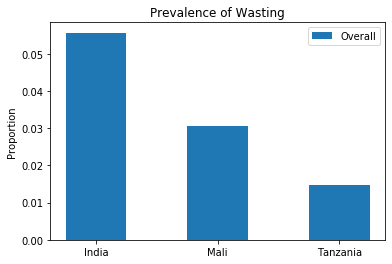

In [172]:
data = master_wasting.sort_values(by='location')

# bar width
barWidth = 0.5

# bar heights
overall = data['percent'].where(data['malnourishment_category'] == 'all').dropna()

#normal = data['percent'].where(data['malnourishment_category'] == 'not_malnourished').dropna()
#malnourished = data['percent'].where(data['malnourishment_category'] == 'malnourished').dropna()

# bar positions
a = np.arange(len(overall))
#b = [x + barWidth for x in a]
#c = [x + barWidth for x in b]

# plot 
plt.bar(a, overall, width=barWidth)
#plt.bar(b, normal, width=barWidth)
#plt.bar(c, malnourished, width=barWidth)
plt.xticks([r for r in range(len(normal))], np.unique(data['location']))
plt.legend(['Overall','BMI > 18.5','BMI < 18.5'])
plt.title('Prevalence of Wasting')
plt.ylabel('Proportion')
#plt.ylim(0,0.25)
plt.savefig('wasting')

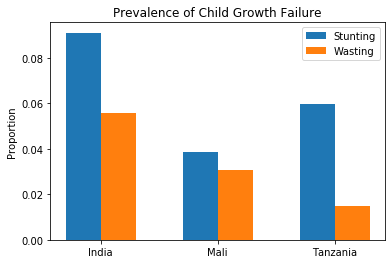

In [178]:
stunting = master_stunting.sort_values(by='location')
wasting = master_wasting.sort_values(by='location')

# bar width
barWidth = 0.3

# bar heights
stunt = stunting['percent'].where(stunting['malnourishment_category'] == 'all').dropna()
wast = wasting['percent'].where(wasting['malnourishment_category'] == 'all').dropna()

# bar positions
a = np.arange(len(stunt))
b = [x + barWidth for x in a]

# plot 
plt.bar(a, stunt, width=barWidth)
plt.bar(b, wast, width=barWidth)
plt.xticks([r + barWidth/2 for r in range(len(normal))], np.unique(data['location']))
plt.legend(['Stunting','Wasting'])
plt.title('Prevalence of Child Growth Failure')
plt.ylabel('Proportion')
#plt.ylim(0,0.25)
plt.savefig('wasting')

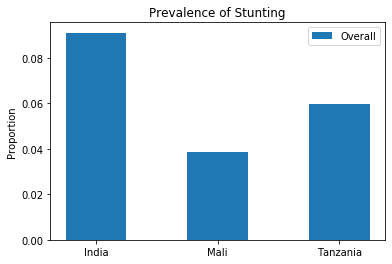

In [174]:
data = master_stunting.sort_values(by='location')

# bar width
barWidth = 0.5

# bar heights
overall = data['percent'].where(data['malnourishment_category'] == 'all').dropna()
#normal = data['percent'].where(data['malnourishment_category'] == 'not_malnourished').dropna()
#malnourished = data['percent'].where(data['malnourishment_category'] == 'malnourished').dropna()

# bar positions
a = np.arange(len(overall))
#b = [x + barWidth for x in a]
#c = [x + barWidth for x in b]

# plot 
plt.bar(a, overall, width=barWidth)
#plt.bar(b, normal, width=barWidth)
#plt.bar(c, malnourished, width=barWidth)
plt.xticks([r for r in range(len(normal))], np.unique(data['location']))
plt.legend(['Overall','BMI > 18.5','BMI < 18.5'])
plt.title('Prevalence of Stunting')
plt.ylabel('Proportion')
#plt.ylim(0,0.25)
plt.savefig('stunting')

In [74]:
stratified = master_bw.groupby(['location','measure','scenario','mother_status']).sum()
stratified['weighted_average'] = stratified['weighted_value'] / stratified['total_population']
stratified = stratified.reset_index()
stratified = stratified.where(stratified['measure'] == 'mean').dropna()#.where(stratified['scenario'] == 'baseline').dropna()
overall = master_bw.groupby(['location','measure','scenario']).sum()
overall['weighted_average'] = overall['weighted_value'] / overall['total_population']
overall = overall.reset_index()
overall = overall.where(overall['measure'] == 'mean').dropna()#.where(overall['scenario'] == 'baseline').dropna()
overall = overall.sort_values(by='location')
overall['mother_status'] = 'overall'
bw = stratified.append(overall)
baseline_bw = (bw.where(bw['scenario'] == 'baseline').dropna()
               .drop(columns=['scenario','weighted_value','total_population','value'])
               .rename(columns={'weighted_average':'baseline_value'}))
mean_bw_diff = bw.merge(baseline_bw, right_on=['location','measure','mother_status'],
                  left_on=['location','measure','mother_status'])
mean_bw_diff['averted'] = bw_diff['baseline_value'] - bw_diff['weighted_average']
mean_bw_diff.head()

/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,location,measure,mother_status,scenario,total_population,value,weighted_average,weighted_value,baseline_value,averted
0,India,mean,malnourished,baseline,16936.5,5367.611570,2683.653692,4.545170e+07,2683.653692,0.000000
1,India,mean,malnourished,bep_scale_up,16936.5,5469.579494,2763.102889,4.679729e+07,2683.653692,0.057366
2,India,mean,malnourished,bep_targeted_scale_up,16936.5,5469.579494,2763.102889,4.679729e+07,2683.653692,0.057366
3,India,mean,malnourished,mmn_scale_up,16936.5,5391.668278,2701.247369,4.574968e+07,2683.653692,0.012613
4,India,mean,normal,baseline,83063.5,6077.116804,3038.565137,2.523939e+08,3038.565137,0.000000


In [87]:

data = mean_bw_diff.where(mean_bw_diff['location'] == 'India').dropna()
data.where(data['scenario'] == 'baseline').dropna()

,location,measure,mother_status,scenario,total_population,value,weighted_average,weighted_value,baseline_value,averted
0,India,mean,malnourished,baseline,16936.5,5367.611570,2683.653692,4.545170e+07,2683.653692,0.0
4,India,mean,normal,baseline,83063.5,6077.116804,3038.565137,2.523939e+08,3038.565137,0.0
32,India,mean,overall,baseline,100000.0,11444.728374,2978.455560,2.978456e+08,2978.455560,0.0


(2500, 3300)

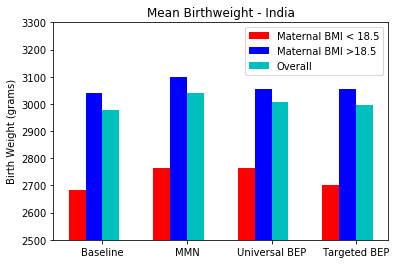

In [132]:
# plot baseline mean birth weight stratified by maternal malnourishment

data = mean_bw_diff.where(mean_bw_diff['location'] == 'India').dropna()

# bar width
barWidth = 0.2

# bar heights
y1 = data['weighted_average'].where(data['mother_status'] == 'malnourished').dropna()
y2 = data['weighted_average'].where(data['mother_status'] == 'normal').dropna()
y3 = data['weighted_average'].where(data['mother_status'] == 'overall').dropna()


# bar positions
a = np.arange(len(y1))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
d = [x + barWidth for x in c]

# plot 
plt.bar(a, y1, width=barWidth, color='r')
plt.bar(b, y2, width=barWidth, color='b')
plt.bar(c, y3, width=barWidth, color='c')
#plt.bar(d, y4, width=barWidth)
plt.xticks([r + 1.5*barWidth for r in range(len(y1))], ['Baseline', 'MMN', 'Universal BEP', 'Targeted BEP'])
plt.legend(['Maternal BMI < 18.5','Maternal BMI >18.5','Overall'])
plt.title('Mean Birthweight - India')
plt.ylabel('Birth Weight (grams)')
plt.ylim(2500,3300)

(0, 4200)

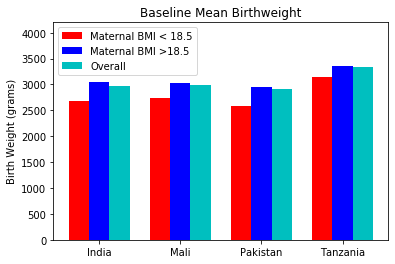

In [131]:
# plot baseline mean birth weight stratified by maternal malnourishment

data = mean_bw_diff.where(mean_bw_diff['scenario'] == 'baseline').dropna()

# bar width
barWidth = 0.25

# bar heights
y1 = data['weighted_average'].where(data['mother_status'] == 'malnourished').dropna()
y2 = data['weighted_average'].where(data['mother_status'] == 'normal').dropna()
y3 = data['weighted_average'].where(data['mother_status'] == 'overall').dropna()
#y4 = data['weighted_average'].where(data['location'] == 'Tanzania').dropna()

# bar positions
a = np.arange(len(y1))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
#d = [x + barWidth for x in c]

# plot 
plt.bar(a, y1, width=barWidth, color='r')
plt.bar(b, y2, width=barWidth, color='b')
plt.bar(c, y3, width=barWidth, color='c')
#plt.bar(d, y4, width=barWidth)
plt.xticks([r + barWidth for r in range(len(y1))], ['India', 'Mali', 'Pakistan', 'Tanzania'])
plt.legend(['Maternal BMI < 18.5','Maternal BMI >18.5','Overall'])
plt.title('Baseline Mean Birthweight')
plt.ylabel('Birth Weight (grams)')
plt.ylim(0,4200)

(2500, 3200)

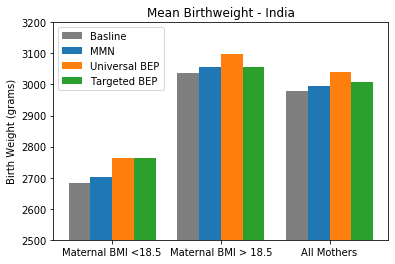

In [133]:
# plot baseline mean birth weight stratified by maternal malnourishment

data = mean_bw_diff.where(mean_bw_diff['location'] == 'India').dropna()

# bar width
barWidth = 0.2

# bar heights
y1 = data['weighted_average'].where(data['scenario'] == 'baseline').dropna()
y2 = data['weighted_average'].where(data['scenario'] == 'mmn_scale_up').dropna()
y3 = data['weighted_average'].where(data['scenario'] == 'bep_scale_up').dropna()
y4 = data['weighted_average'].where(data['scenario'] == 'bep_targeted_scale_up').dropna()

# bar positions
a = np.arange(len(y1))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
d = [x + barWidth for x in c]

# plot 
plt.bar(a, y1, width=barWidth, color='tab:grey')
plt.bar(b, y2, width=barWidth)
plt.bar(c, y3, width=barWidth)
plt.bar(d, y4, width=barWidth)
plt.xticks([r + 1.5*barWidth for r in range(len(y1))], ['Maternal BMI <18.5', 'Maternal BMI > 18.5', 'All Mothers'])
plt.legend(['Basline','MMN','Universal BEP','Targeted BEP'])
plt.title('Mean Birthweight - India')
plt.ylabel('Birth Weight (grams)')
plt.ylim(2500,3200)

(2500, 3200)

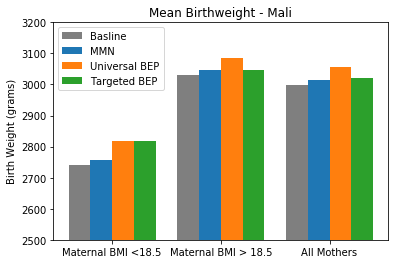

In [134]:
# plot baseline mean birth weight stratified by maternal malnourishment

data = mean_bw_diff.where(mean_bw_diff['location'] == 'Mali').dropna()

# bar width
barWidth = 0.2

# bar heights
y1 = data['weighted_average'].where(data['scenario'] == 'baseline').dropna()
y2 = data['weighted_average'].where(data['scenario'] == 'mmn_scale_up').dropna()
y3 = data['weighted_average'].where(data['scenario'] == 'bep_scale_up').dropna()
y4 = data['weighted_average'].where(data['scenario'] == 'bep_targeted_scale_up').dropna()

# bar positions
a = np.arange(len(y1))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
d = [x + barWidth for x in c]

# plot 
plt.bar(a, y1, width=barWidth, color='tab:grey')
plt.bar(b, y2, width=barWidth)
plt.bar(c, y3, width=barWidth)
plt.bar(d, y4, width=barWidth)
plt.xticks([r + 1.5*barWidth for r in range(len(y1))], ['Maternal BMI <18.5', 'Maternal BMI > 18.5', 'All Mothers'])
plt.legend(['Basline','MMN','Universal BEP','Targeted BEP'])
plt.title('Mean Birthweight - Mali')
plt.ylabel('Birth Weight (grams)')
plt.ylim(2500,3200)

(2500, 3200)

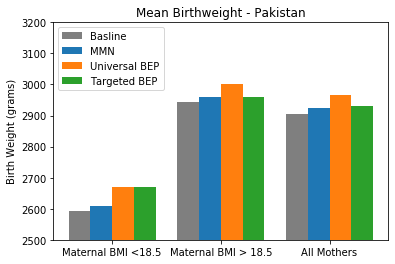

In [135]:
# plot baseline mean birth weight stratified by maternal malnourishment

data = mean_bw_diff.where(mean_bw_diff['location'] == 'Pakistan').dropna()

# bar width
barWidth = 0.2

# bar heights
y1 = data['weighted_average'].where(data['scenario'] == 'baseline').dropna()
y2 = data['weighted_average'].where(data['scenario'] == 'mmn_scale_up').dropna()
y3 = data['weighted_average'].where(data['scenario'] == 'bep_scale_up').dropna()
y4 = data['weighted_average'].where(data['scenario'] == 'bep_targeted_scale_up').dropna()

# bar positions
a = np.arange(len(y1))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
d = [x + barWidth for x in c]

# plot 
plt.bar(a, y1, width=barWidth, color='tab:grey')
plt.bar(b, y2, width=barWidth)
plt.bar(c, y3, width=barWidth)
plt.bar(d, y4, width=barWidth)
plt.xticks([r + 1.5*barWidth for r in range(len(y1))], ['Maternal BMI <18.5', 'Maternal BMI > 18.5', 'All Mothers'])
plt.legend(['Basline','MMN','Universal BEP','Targeted BEP'], loc='upper left')
plt.title('Mean Birthweight - Pakistan')
plt.ylabel('Birth Weight (grams)')
plt.ylim(2500,3200)

(3000, 3500)

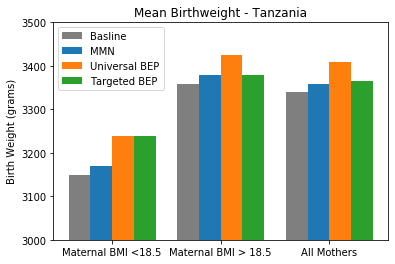

In [136]:
# plot baseline mean birth weight stratified by maternal malnourishment

data = mean_bw_diff.where(mean_bw_diff['location'] == 'Tanzania').dropna()

# bar width
barWidth = 0.2

# bar heights
y1 = data['weighted_average'].where(data['scenario'] == 'baseline').dropna()
y2 = data['weighted_average'].where(data['scenario'] == 'mmn_scale_up').dropna()
y3 = data['weighted_average'].where(data['scenario'] == 'bep_scale_up').dropna()
y4 = data['weighted_average'].where(data['scenario'] == 'bep_targeted_scale_up').dropna()

# bar positions
a = np.arange(len(y1))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
d = [x + barWidth for x in c]

# plot 
plt.bar(a, y1, width=barWidth, color='tab:grey')
plt.bar(b, y2, width=barWidth)
plt.bar(c, y3, width=barWidth)
plt.bar(d, y4, width=barWidth)
plt.xticks([r + 1.5*barWidth for r in range(len(y1))], ['Maternal BMI <18.5', 'Maternal BMI > 18.5', 'All Mothers'])
plt.legend(['Basline','MMN','Universal BEP','Targeted BEP'])
plt.title('Mean Birthweight - Tanzania')
plt.ylabel('Birth Weight (grams)')
plt.ylim(3000,3500)